In [1]:
import random
import matplotlib.pyplot as plt
import math
import time
import itertools

In [2]:
habitable_width, habitable_length = 100, 100
probability_of_genome_mutation = 0.2

In [3]:
#initializing probability by choosing (probability_of_genome_mutation*100) numbers, so whenever one of these numbers is chosen during reproduction, mutation takes place
numbers_to_mutate = []
for i in range(int(probability_of_genome_mutation*100)):
    temp = random.randint(1, 100)
    while(temp in numbers_to_mutate):
        temp = random.randint(1, 100)
    numbers_to_mutate.append(temp)

In [4]:
class Location:
    __slots__ = ('x', 'y')
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__ (self, other):
        return (self.x == other.x) and (self.y == other.y)
        
    def __hash__ (self):
        return hash((self.x, self.y))

In [5]:
def random_house_location():
    #naming the side on x-axis '1' and the following sides similarly in clockwise direction
    chosen_side = random.randint(1, 4)
    match chosen_side:
        case 1:
            return Location(x = random.randrange(0, habitable_length), y = 0)
        case 2:
            return Location(x = habitable_length, y = random.randrange(1, habitable_width))
        case 3:
            return Location(x = random.randrange(0, habitable_length - 1), y = habitable_width)
        case 4:
            return Location(x = 0, y = random.randrange(1, habitable_width - 1))

In [6]:
class Genome:
    __slots__ = ('genome', 'fitness')
    def __init__(
        self,
        genome: str,
        fitness = None
    ):
        self.genome = genome
        self.fitness = (genome.count('A') * 4) + (genome.count('C') * 3) + (genome.count('G') * 2) + (genome.count('T'))
        #therefore, organisms with more number of 'A' are fitter

    def mutate(self):
        #attempt to change a character in genome string
        char_list = list(self.genome)
        char_list[random.randint(0, 3)] = random.choice(['A', 'C', 'G', 'T'])
        self.genome = "".join(char_list)
        #update fitness based on new genome string
        self.fitness = (self.genome.count('A') * 4) + (self.genome.count('C') * 3) + (self.genome.count('G') * 2) + (self.genome.count('T'))
    
    def shuffle(self):
        x = self.genome
        letters = [x[_] for _ in range(len(x))] #split genome string
        new_order_of_letters = []
        not_used = [_ for _ in range(len(x))] #letters with no position allotted
        for _ in range(len(x)):
            new_order_of_letters.append(random.choice(not_used))
            not_used.remove(new_order_of_letters[-1])
        shuffled_string = ""
        for i in range(len(x)):
            shuffled_string = shuffled_string + (letters[new_order_of_letters[i]])
        self.genome = shuffled_string

In [7]:
class Organism:
    __slots__ = ('location', 'health', 'energy', 'mass', 'genome', 'energy_required_to_survive', 'surplus_energy_to_reproduce')
    def __init__(
        self,
        location: Location,
        health: float = 1,
        energy: float = 15,
        mass: float = 1,
        genome: Genome = Genome(genome = "ATGC"),
        energy_required_to_survive: float = 10,
        surplus_energy_to_reproduce: float = 10,
    ):
        self.health = health
        self.energy = energy
        self.mass = mass
        self.location = location
        self.genome = genome
        self.energy_required_to_survive = (energy_required_to_survive) * (16 / genome.fitness) #current amount of energy required, if excess by an amount delta than reproduce
        self.surplus_energy_to_reproduce = (surplus_energy_to_reproduce) * (16 / genome.fitness) # if energy surplus == this amount, then reproduce
    
    def isAlive(self):
        return self.health > 0
    
    def speed(self):
        return math.sqrt(2*self.energy/self.mass)
    
    def move(self):
        self.location.x += random.choice([-1, 0, 1])
        while(self.location.x > habitable_length):
            self.location.x -= 1
        while(self.location.x < 0):
            self.location.x += 1

        self.location.y += random.choice([-1, 0, 1])
        while(self.location.y > habitable_width):
            self.location.y -=1
        while(self.location.y < 0):
            self.location.y += 1

In [8]:
class Food:
    __slots__ = ('energy', 'location')
    def __init__(
        self,
        location: Location,
        energy: float,
    ):
        self.energy = energy
        self.location = location

In [9]:
def airdrop_food(food_quantity):
    food_map = {}
    while(len(food_map) < food_quantity):
        location = Location(random.randint(2, habitable_length - 1), random.randint(2, habitable_width - 1))
        if location not in food_map:
            food_map[location] = Food(energy = random.randrange(8, 10), location = location)
    return food_map

In [10]:
def play_game(being_1, being_2):
    #returns 1 if being_1 wins
    return random.choice([0, 0.5, 1])

In [11]:
def simulate(food_airdropped_per_day, total_organisms, max_days):

    #initialization
    organisms = [Organism(location = random_house_location()) for _ in range(total_organisms // 2)]
    organisms.extend([Organism(location = random_house_location(), genome = Genome(genome = "AATT")) for _ in range(total_organisms - total_organisms // 2)])
    genome_count_history = {}
    for combination in itertools.product("ATGC", repeat = 4):
        genome_count_history["".join(combination)] = [0 for _ in range(max_days + 1)]
    genome_count_history["ATGC"][0] = total_organisms // 2
    genome_count_history["AATT"][0] = total_organisms - total_organisms // 2
    organisms_alive = total_organisms
    organism_count_history = [organisms_alive]
    food_map = airdrop_food(food_airdropped_per_day)
    time_of_day_in_sec = 0
    days_passed = 0
    data_dump = [[{} for _ in range(seconds_in_a_day + 1)] for _ in range(max_days + 1)]
    data_dump[0][0] = {id(being): (being.location.x, being.location.y) for being in organisms}
    identity = {}
    for being in organisms:
        identity[id(being)] = being.genome.genome
    food_history = [[None for _ in range(seconds_in_a_day + 1)] for _ in range(max_days + 1)]
    food_history[0][0] = {loc: food for loc, food in food_map.items()}

    while days_passed < max_days:

        stop_clock = False
        while not stop_clock:
            time_of_day_in_sec += 1
            being_to_delete = []
        
            for being in organisms[:]:      #
                if being.isAlive():         # Move all beings
                    being.move()            #
                    data_dump[days_passed][time_of_day_in_sec][id(being)] = (being.location.x, being.location.y)
                    identity[id(being)] = being.genome.genome
                else:  
                    organisms.remove(being)
                    organisms_alive -= 1       

            i_finds_food = False
            i_meets_j = -1
            for i in range(len(organisms)):

                if organisms[i].isAlive():
                    i_meets_j = -1 #value of j, -1 means it has not met anyone
                    i_finds_food = False

                    for j in range(i+1, len(organisms)):
                        if not organisms[j].isAlive():
                            continue
                        if organisms[i].location == organisms[j].location:
                            i_meets_j = j
                            break

                    if organisms[i].location in food_map:
                        i_finds_food = True

                    if i_finds_food and not i_meets_j == -1:
                        #distribute food among i and j based on the result of a game between i and j
                        #for game, 1 indicates winning, 0 for losing and 0.5 for a draw
                        i_wins = play_game(organisms[i], organisms[i_meets_j])
                        organisms[i].energy += i_wins * food_map[organisms[i].location].energy
                        organisms[i_meets_j].energy += (1 - i_wins) * food_map[organisms[i_meets_j].location].energy
                        del food_map[organisms[i].location]
                    elif i_finds_food and i_meets_j == -1:
                        organisms[i].energy += food_map[organisms[i].location].energy
                        del food_map[organisms[i].location]
                    elif not i_finds_food and not i_meets_j == -1:
                        i_wins = play_game(organisms[i], organisms[i_meets_j])
                        #winner gets 20% energy of the loser
                        if i_wins == 1:
                            organisms[i].energy += (0.2) * (organisms[i_meets_j].energy)
                            organisms[i_meets_j].energy *= 0.8
                        elif i_wins == 0:
                            organisms[i_meets_j].energy += (0.2) * (organisms[i].energy)
                            organisms[i].energy *= 0.8
                        #else no energy transfer
            
            food_history[days_passed][time_of_day_in_sec] = {loc: food for loc, food in food_map.items()}

            if time_of_day_in_sec == seconds_in_a_day: # A day has passed, now check who has the energy to survive 
                days_passed += 1
                time_of_day_in_sec = 0
                stop_clock = True
                for i in range(len(organisms)):
                    if organisms[i].energy >= organisms[i].energy_required_to_survive:
                        # being survives
                        organisms[i].health -= 0.16/(organisms[i].genome.fitness) #organism's health depletes as it ages
                        organisms[i].energy -= organisms[i].energy_required_to_survive
                        if organisms[i].energy >= organisms[i].surplus_energy_to_reproduce:
                            #being reproduces
                            for _ in range(2): #produces two offsprings
                                new_being = Organism(
                                    location = random_house_location(),
                                    genome = Genome(genome = organisms[i].genome.genome), # inherits genome from parent
                                    mass = organisms[i].mass,
                                    energy_required_to_survive = organisms[i].energy_required_to_survive,
                                    surplus_energy_to_reproduce = organisms[i].surplus_energy_to_reproduce,
                                )
                                if random.randint(1, 100) in numbers_to_mutate:
                                    #mutate
                                    new_being.genome.mutate()
                                    new_being.energy_required_to_survive = (organisms[i].energy_required_to_survive) * (16 / organisms[i].genome.fitness) 
                                    new_being.surplus_energy_to_reproduce = (organisms[i].surplus_energy_to_reproduce) * (16 / organisms[i].genome.fitness)
                                organisms.append(new_being)
                                organisms_alive += 1
                            organisms[i].energy -= organisms[i].surplus_energy_to_reproduce
                        #being is still alive, therefore, it goes back to the village
                        organisms[i].location = random_house_location()
                    else:
                        #being dies                          
                        being_to_delete.append(i)
                        organisms_alive -= 1

                being_to_delete.sort(reverse = True)
                for i in being_to_delete:
                    del organisms[i]

                for being in organisms:
                    genome_count_history[being.genome.genome][days_passed] += 1
                    data_dump[days_passed][time_of_day_in_sec][id(being)] = (being.location.x, being.location.y)
                    identity[id(being)] = being.genome.genome

                organism_count_history.append(organisms_alive)
                print(f"End of Day {days_passed}/{max_days}: {organisms_alive} organisms alive, food left = {len(food_map)}")
                food_map = airdrop_food(food_quantity = food_airdropped_per_day)
                food_history[days_passed][time_of_day_in_sec] = {loc: food for loc, food in food_map.items()}
    return organism_count_history, genome_count_history, data_dump, identity, food_history

In [12]:
max_days, seconds_in_a_day = 200, 500
organism_count_history, genome_count_history, data_dump, identity, food_history = simulate(food_airdropped_per_day = 1000, total_organisms = 20, max_days = max_days)

End of Day 1/200: 60 organisms alive, food left = 714
End of Day 2/200: 170 organisms alive, food left = 433
End of Day 3/200: 318 organisms alive, food left = 209
End of Day 4/200: 363 organisms alive, food left = 128
End of Day 5/200: 263 organisms alive, food left = 123
End of Day 6/200: 254 organisms alive, food left = 198
End of Day 7/200: 258 organisms alive, food left = 120
End of Day 8/200: 206 organisms alive, food left = 184
End of Day 9/200: 212 organisms alive, food left = 206
End of Day 10/200: 227 organisms alive, food left = 179
End of Day 11/200: 220 organisms alive, food left = 169
End of Day 12/200: 208 organisms alive, food left = 192
End of Day 13/200: 206 organisms alive, food left = 201
End of Day 14/200: 187 organisms alive, food left = 187
End of Day 15/200: 223 organisms alive, food left = 180
End of Day 16/200: 211 organisms alive, food left = 150
End of Day 17/200: 193 organisms alive, food left = 201
End of Day 18/200: 199 organisms alive, food left = 171
En

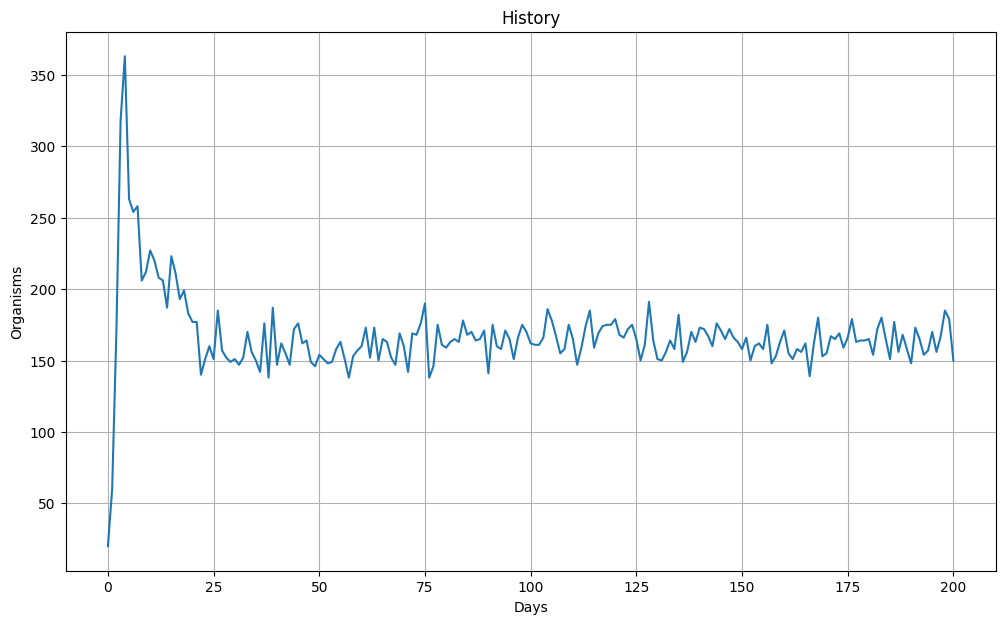

In [13]:
plt.figure(figsize = (12, 7))
plt.plot(organism_count_history)
plt.title("History")
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Organisms')
plt.show()

In [14]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Prepare the data for plotting
data = []
for genome, history in genome_count_history.items():
    if sum(history) > 0:  # Only plot genomes that have non-zero counts at some point
        trace = go.Scatter(
            x=list(range(len(history))),
            y=history,
            mode='markers',
            name=genome,
            marker=dict(size=6)
        )
        data.append(trace)

# Define the layout
layout = go.Layout(
    title='Population History of Different Genomes',
    xaxis=dict(title='Days'),
    yaxis=dict(title='Number of Organisms'),
    legend=dict(x=1, y=0.5, bgcolor='rgba(255, 255, 255, 0)', bordercolor='rgba(255, 255, 255, 0)')
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Plot the figure
pyo.plot(fig, filename='genome_population_history.html')



'genome_population_history.html'

In [15]:
import pygame
import sys
from collections import defaultdict
import math

def genome_to_color(genome, unique_genomes):
    color_map = {'A': (255, 0, 0), 'T': (0, 255, 0), 'G': (0, 0, 255), 'C': (255, 255, 0)}
    r = (color_map[genome[0]][0] + color_map[genome[2]][0]) // 2
    g = (color_map[genome[1]][1] + color_map[genome[3]][1]) // 2
    b = (color_map[genome[0]][2] + color_map[genome[1]][2] + color_map[genome[2]][2] + color_map[genome[3]][2]) // 4
    return (r, g, b)

def visualize_simulation(data_dump, identity, food_history, max_days, seconds_in_a_day, habitable_length, habitable_width):
    pygame.init()

    # Set up display in full screen mode
    infoObject = pygame.display.Info()
    width, height = infoObject.current_w, infoObject.current_h
    screen = pygame.display.set_mode((width, height), pygame.FULLSCREEN)
    pygame.display.set_caption("Ecosystem Simulation")

    # Set up clock and font
    clock = pygame.time.Clock()
    font = pygame.font.SysFont('Arial', 18) 
    large_font = pygame.font.SysFont('Arial', 60)

    grid_width = width - 420
    grid_height = height - 180
    scale_x = grid_width / habitable_length
    scale_y = grid_height / habitable_width

    # Get unique genomes for legend
    unique_genomes = list(set(identity.values()))

    # Colors and styles
    BACKGROUND_COLOR = (240, 248, 255)  # Light blue background
    GRID_COLOR = (200, 220, 240)
    FOOD_COLOR = (139, 69, 19)  # Brown for food
    BORDER_COLOR = (70, 130, 180)  # Steel blue for border
    BUTTON_COLOR = (255, 0, 0)  # Red for buttons
    BUTTON_TEXT_COLOR = (255, 255, 255)

    # Button dimensions and positions
    button_radius = 30
    pause_button_x, pause_button_y = 110, height - 50
    stop_button_x, stop_button_y = 210, height - 50
    start_button_x, start_button_y = 10, height - 50

    # Jump to day interface
    jump_to_day_x, jump_to_day_y = width - 200, height - 50
    jump_to_day_width, jump_to_day_height = 100, 30
    jump_to_day_text = font.render("Jump to Day", True, (0, 0, 0))
    jump_to_day_input = pygame.Rect(jump_to_day_x, jump_to_day_y, jump_to_day_width, jump_to_day_height)
    jump_to_day_active = False
    jump_to_day_value = ""

    # Main loop
    day = 0
    second = 0
    running = True
    paused = True
    started = False
    show_day_message = False

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    paused = not paused
                elif event.key == pygame.K_ESCAPE:
                    running = False
                elif jump_to_day_active:
                    if event.key == pygame.K_RETURN:
                        if jump_to_day_value.isdigit():
                            day = min(max(0, int(jump_to_day_value) - 1), max_days - 1)
                            second = 0
                            jump_to_day_value = ""
                            jump_to_day_active = False
                    elif event.key == pygame.K_BACKSPACE:
                        jump_to_day_value = jump_to_day_value[:-1]
                    else:
                        jump_to_day_value += event.unicode
            elif event.type == pygame.MOUSEBUTTONDOWN:
                mouse_pos = pygame.mouse.get_pos()
                if (pause_button_x - button_radius <= mouse_pos[0] <= pause_button_x + button_radius and
                    pause_button_y - button_radius <= mouse_pos[1] <= pause_button_y + button_radius):
                    paused = not paused
                elif (stop_button_x - button_radius <= mouse_pos[0] <= stop_button_x + button_radius and
                      stop_button_y - button_radius <= mouse_pos[1] <= stop_button_y + button_radius):
                    running = False
                elif (start_button_x - button_radius <= mouse_pos[0] <= start_button_x + button_radius and
                      start_button_y - button_radius <= mouse_pos[1] <= start_button_y + button_radius):
                    started = True
                    paused = False
                elif jump_to_day_input.collidepoint(mouse_pos):
                    jump_to_day_active = True
                else:
                    jump_to_day_active = False

        if started and not paused:
            # Clear the screen
            screen.fill(BACKGROUND_COLOR)

            # Draw grid
            for x in range(0, grid_width + 1, int(scale_x)):
                pygame.draw.line(screen, GRID_COLOR, (x + 10, 30), (x + 10, grid_height + 30))
            for y in range(0, grid_height + 1, int(scale_y)):
                pygame.draw.line(screen, GRID_COLOR, (10, y + 30), (grid_width + 10, y + 30))

            # Draw border
            pygame.draw.rect(screen, BORDER_COLOR, (10, 30, grid_width, grid_height), 2)

            # Draw food
            for food_location, food_item in food_history[day][second].items():
                x, y = food_location.x, food_location.y
                energy = food_item.energy
                size = energy/2.0
                pygame.draw.circle(screen, FOOD_COLOR, (int(x * scale_x) + 10, int(y * scale_y) + 30), size)

            # Draw organisms
            for org_id, coord in data_dump[day][second].items():
                x, y = coord
                color = genome_to_color(identity[org_id], unique_genomes)
                pygame.draw.circle(screen, color, (int(x * scale_x) + 10, int(y * scale_y) + 30), 6)
                pygame.draw.circle(screen, (0, 0, 0), (int(x * scale_x) + 10, int(y * scale_y) + 30), 6, 1)  # Black outline

            # Display current day and time
            day_text = font.render(f"Day: {day + 1}/{max_days}", True, (0, 0, 0))
            time_text = font.render(f"Time: {second}/{seconds_in_a_day} seconds", True, (0, 0, 0))
            organism_count_text = font.render(f"Total organism = {len(data_dump[day][second])}", True, (0, 0, 0))
            food_count_text = font.render(f"Food quantity = {len(food_history[day][second])}", True, (0, 0, 0))
            screen.blit(day_text, (15, 5))
            screen.blit(time_text, (200, 5))
            screen.blit(organism_count_text, (width // 2, height - 50))
            screen.blit(food_count_text, (width // 2, height - 30))

            # Move to next second
            second += 1
            if second >= seconds_in_a_day:
                second = 0
                day += 1
                show_day_message = True
                if day >= max_days:
                    day = 0

        else:
            # Clear the screen
            screen.fill(BACKGROUND_COLOR)

            # Draw grid
            for x in range(0, grid_width + 1, int(scale_x)):
                pygame.draw.line(screen, GRID_COLOR, (x + 10, 30), (x + 10, grid_height + 30))
            for y in range(0, grid_height + 1, int(scale_y)):
                pygame.draw.line(screen, GRID_COLOR, (10, y + 30), (grid_width + 10, y + 30))

            # Draw border
            pygame.draw.rect(screen, BORDER_COLOR, (10, 30, grid_width, grid_height), 2)

            # Draw food
            for food_location, food_item in food_history[day][second].items():
                x, y = food_location.x, food_location.y
                energy = food_item.energy
                size = energy/2.0
                pygame.draw.circle(screen, FOOD_COLOR, (int(x * scale_x) + 10, int(y * scale_y) + 30), size)

            # Draw organisms
            for org_id, coord in data_dump[day][second].items():
                x, y = coord
                color = genome_to_color(identity[org_id], unique_genomes)
                pygame.draw.circle(screen, color, (int(x * scale_x) + 10, int(y * scale_y) + 30), 6)
                pygame.draw.circle(screen, (0, 0, 0), (int(x * scale_x) + 10, int(y * scale_y) + 30), 6, 1)  # Black outline

            # Display current day and time
            day_text = font.render(f"Day: {day + 1}/{max_days}", True, (0, 0, 0))
            time_text = font.render(f"Time: {second}/{seconds_in_a_day} seconds", True, (0, 0, 0))
            organism_count_text = font.render(f"Total organism = {len(data_dump[day][second])}", True, (0, 0, 0))
            food_count_text = font.render(f"Food quantity = {len(food_history[day][second])}", True, (0, 0, 0))
            screen.blit(day_text, (15, 5))
            screen.blit(time_text, (200, 5))
            screen.blit(organism_count_text, (width // 2, height - 50))
            screen.blit(food_count_text, (width // 2, height - 30))

        # Draw legend
        legend_x = width - 400 
        legend_y = 30
        pygame.draw.rect(screen, (240, 240, 240), (legend_x - 10, legend_y - 10, 400, height - 160), border_radius=10)
        legend_title = font.render("Genome Colors", True, (0, 0, 0))
        screen.blit(legend_title, (legend_x, legend_y))
        num_columns = 2
        genomes_per_column = len(unique_genomes) // num_columns + (len(unique_genomes) % num_columns > 0)
        for i, genome in enumerate(unique_genomes):
            column = i // genomes_per_column
            row = i % genomes_per_column
            color = genome_to_color(genome, unique_genomes)
            pygame.draw.circle(screen, color, (legend_x + 10 + column * 190, legend_y + 40 + row * 25), 6)
            pygame.draw.circle(screen, (0, 0, 0), (legend_x + 10 + column * 190, legend_y + 40 + row * 25), 6, 1)  # Black outline
            genome_text = font.render(genome, True, (0, 0, 0))
            screen.blit(genome_text, (legend_x + 25 + column * 190, legend_y + 33 + row * 25))

        # Add food to legend
        food_y = legend_y + 50 + genomes_per_column * 25
        pygame.draw.circle(screen, FOOD_COLOR, (legend_x + 10, food_y), 4)
        food_text = font.render("Food", True, (0, 0, 0))
        screen.blit(food_text, (legend_x + 25, food_y - 7))

        # Draw buttons
        pygame.draw.circle(screen, BUTTON_COLOR, (pause_button_x, pause_button_y), button_radius)
        pygame.draw.circle(screen, BUTTON_COLOR, (stop_button_x, stop_button_y), button_radius)
        pygame.draw.circle(screen, BUTTON_COLOR, (start_button_x, start_button_y), button_radius)
        pause_text = font.render("||", True, BUTTON_TEXT_COLOR)
        stop_text = font.render("X", True, BUTTON_TEXT_COLOR)
        start_text = font.render(">", True, BUTTON_TEXT_COLOR)
        screen.blit(pause_text, (pause_button_x - pause_text.get_width() // 2, pause_button_y - pause_text.get_height() // 2))
        screen.blit(stop_text, (stop_button_x - stop_text.get_width() // 2, stop_button_y - stop_text.get_height() // 2))
        screen.blit(start_text, (start_button_x - start_text.get_width() // 2, start_button_y - start_text.get_height() // 2))

        # Draw jump to day interface
        pygame.draw.rect(screen, (255, 255, 255), jump_to_day_input)
        pygame.draw.rect(screen, (0, 0, 0), jump_to_day_input, 2)
        jump_to_day_value_text = font.render(jump_to_day_value, True, (0, 0, 0))
        screen.blit(jump_to_day_text, (jump_to_day_x - jump_to_day_text.get_width() - 10, jump_to_day_y))
        screen.blit(jump_to_day_value_text, (jump_to_day_x + 5, jump_to_day_y + 5))

        # Show day message
        if show_day_message:
            day_message = large_font.render(f"Day {day + 1}", True, (0, 0, 0))
            message_rect = day_message.get_rect(center=(width // 2, height // 2))
            screen.blit(day_message, message_rect)
            pygame.display.flip()
            pygame.time.wait(1000)  # Display the message for 1 second
            show_day_message = False

        # Update display
        pygame.display.flip()

        # Control frame rate
        clock.tick(20)

    pygame.quit()

visualize_simulation(data_dump, identity, food_history, max_days, seconds_in_a_day, habitable_length, habitable_width)

pygame 2.5.2 (SDL 2.28.3, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html
